# Edafa on PASCAL VOC dataset

This notebook shows an example on how to use Edafa to obtain better results on **segmentation task**. We use [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset which has **20 classes**. We use code and pretrained weights of [Deeplab v3+](https://github.com/tensorflow/models/tree/master/research/deeplab) in Tensorflow. At the end we compare results of the same model with and without augmentations.

#### Import dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# add our package and deeplab directories to the path
import sys
sys.path.append('../../')
sys.path.append('../')
sys.path.append('deepLab/')

In [3]:
import cv2 
import numpy as np
from deeplab import DeepLabModel,vis_segmentation
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from six.moves import urllib
from utils import color_map,multi_iou
%matplotlib inline

#### Constants

In [4]:
# Filename to use for comparison (3 sample files are given in 'data' folder)
FILE = '000033' 

# Input size of the deeplab model
IN_SIZE = 513

#### Now we download pretrained weights and build our model 

In [5]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz'
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir= 'weights'
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX, download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


#### Load the image and corresponding mask

In [6]:
img = cv2.imread("../data/images/%s.jpg"%FILE)
gt = cv2.imread("../data/masks/%s.png"%FILE)

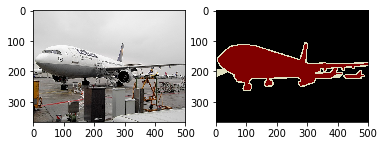

In [7]:
# plot them
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img[:,:,[2,1,0]])
axarr[1].imshow(gt[:,:,[2,1,0]])

In [8]:
# map the RGB value to the corresponding classes
gt = gt[:,:,[2,1,0]]
cmap = color_map()
new_gt = np.zeros(gt.shape[:2],dtype=np.uint8)
for i,c in enumerate(cmap):
    cond = np.logical_and(np.logical_and(gt[:,:,0]==c[0], gt[:,:,1]==c[1]), gt[:,:,2]==c[2])
    new_gt[cond] = i
new_gt[new_gt==255] =0

### Exp1: Predict image without augmentation

/user/akhalel/home/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


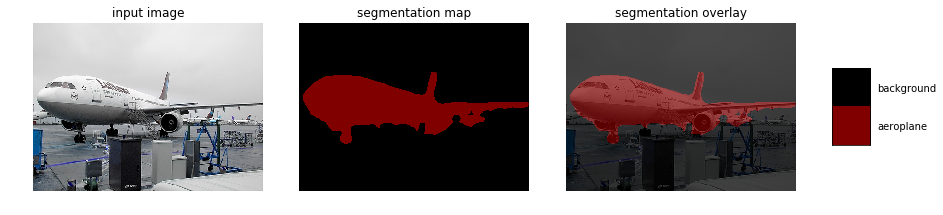

In [9]:
without_aug = MODEL.run(img)
vis_segmentation(img, without_aug)

### Exp2: Using same model with Edafa

#### step 1: import base class `SegPredictor`

In [10]:
from edafa import SegPredictor

#### step 2: inherit `SegPredictor` and implement the main virtual functions: predict_patches()

In [11]:
class myPredictor(SegPredictor):
    def __init__(self,model,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.deeplab_model = model

    def predict_patches(self,patches):
        res = []
        for i in range(patches.shape[0]):
            seg_map=self.deeplab_model.run(patches[i,...])
            res.append(seg_map[np.newaxis,:,:,np.newaxis])
        return np.concatenate(res,axis=0)

#### step 3: make an instance of your class with the correct parameters

In [12]:
conf = '{ \
            "augs": ["NO", "FLIP_LR","BRIGHT"],\
            "mean":"ARITH",\
            "bits":8\
        }'

In [13]:
p = myPredictor(MODEL,IN_SIZE,1,conf)

#### step 4: call predict_images()

In [14]:
with_aug = p.predict_images([img],overlap=0)[0,:,:,0]
# with_aug = postprocess(with_aug,pad_x)

/user/akhalel/home/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


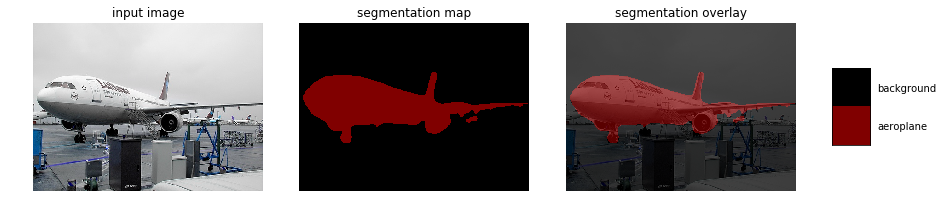

In [15]:
# Visualize the output 
vis_segmentation(img, with_aug.astype(np.uint8))

### Compare results of Exp1 and Exp2

In [16]:
print('IoU with no augmentation: %.6f'%multi_iou(new_gt,without_aug))
print('IoU with augmentation: %.6f'%multi_iou(new_gt,with_aug))

IoU with no augmentation: 0.902870
IoU with augmentation: 0.911801


### Conclusion
Results showed that with the exact same model and by applying Edafa we can obtain better results!